# SNIS IPLA

## IPLA

In [1]:
import numpy as np
from implementation import IPLA, SNIS_IPLA
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 200

In [2]:
def log_p_grad_theta(theta, x, y):
    D = x.shape[0]
    return -(np.sum(x) - D*theta)

def U(theta, Xi, y):
    D = np.shape(Xi)[0]
    return D * np.log(2*np.pi) + np.sum((Xi-theta)**2/2) + np.sum((y-Xi)**2/2)

def U_grad_X(theta, X, y):
    return -(-2*X + y + theta)

def U_grad_theta(theta, Xi, y):
    D = np.shape(Xi)[0]
    return D*(theta - np.mean(Xi))

def ave_grad_U_theta(theta, X, y):
    D, N = np.shape(X)
    return D*(theta - np.mean(X))

grads_U_IPLA = (ave_grad_U_theta, U_grad_X)
grads_U_SNIS = (U_grad_theta, U_grad_X)

In [3]:
D = 100
thdata = 1
nsteps = 300
Nparticles = 10

y = np.random.normal(0,1, (D,1)) + np.random.normal(thdata, 1, (D,1))
th0  = np.array([0.0])
X0 = np.zeros((D, Nparticles))

import importlib
import implementation
importlib.reload(implementation)
IPLA_test = IPLA(th0, X0, grads_U_IPLA, gamma=2.01/(2+D), y=y)
for i in range(nsteps):
    IPLA_test.iterate()

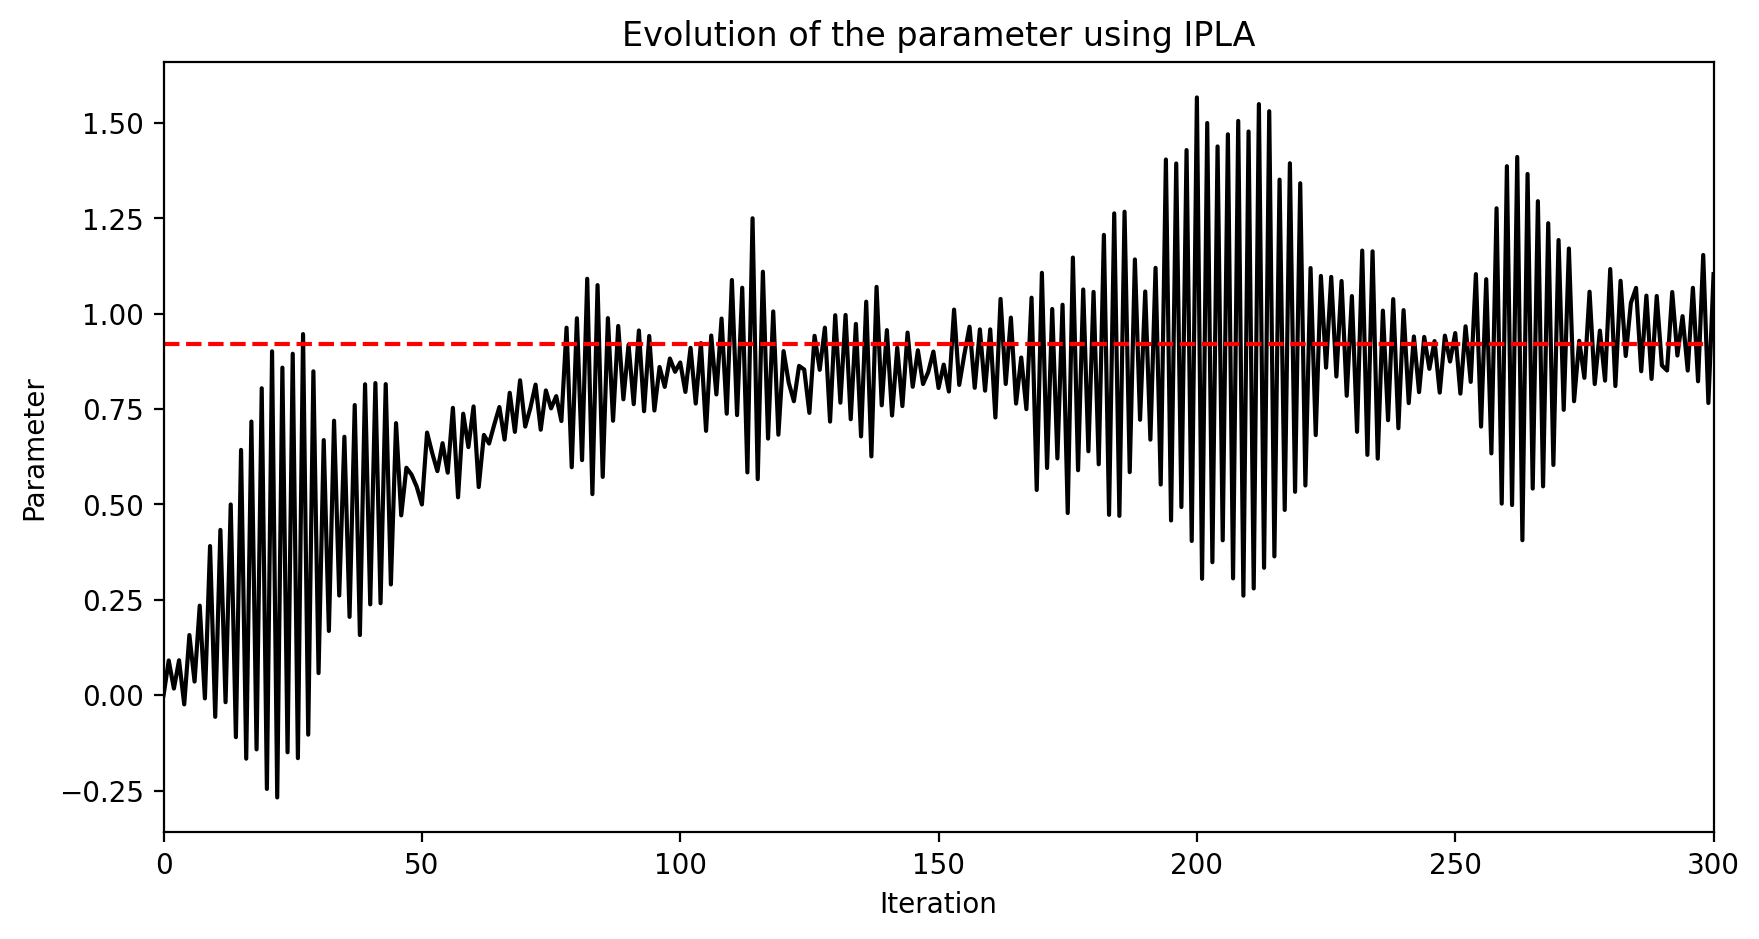

In [4]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(IPLA_test.thetas, color = "black")
plt.plot([0.92]*nsteps, '--', color = "red")
plt.xlabel('Iteration')
plt.ylabel('Parameter')
plt.xlim([0, nsteps])
plt.title('Evolution of the parameter using IPLA')
plt.show()

# SNIS IPLA

In [17]:
D = 100
thdata = 1
nsteps = 300
Nparticles = 100
gamma_SNIS = 2/(2+D)

y = np.random.normal(0,1, (D,1)) + np.random.normal(thdata, 1, (D,1))
th0  = np.array([0.0])
X0 = np.zeros((D, Nparticles))

import importlib
import implementation
importlib.reload(implementation)
SNIS_IPLA_test = SNIS_IPLA(th0, X0, U, grads_U_SNIS, gamma=gamma_SNIS, y=y)
SNIS_IPLA_test.grad_U_X_fn(th0, X0[:,0])
for i in range(nsteps):
    SNIS_IPLA_test.iterate()

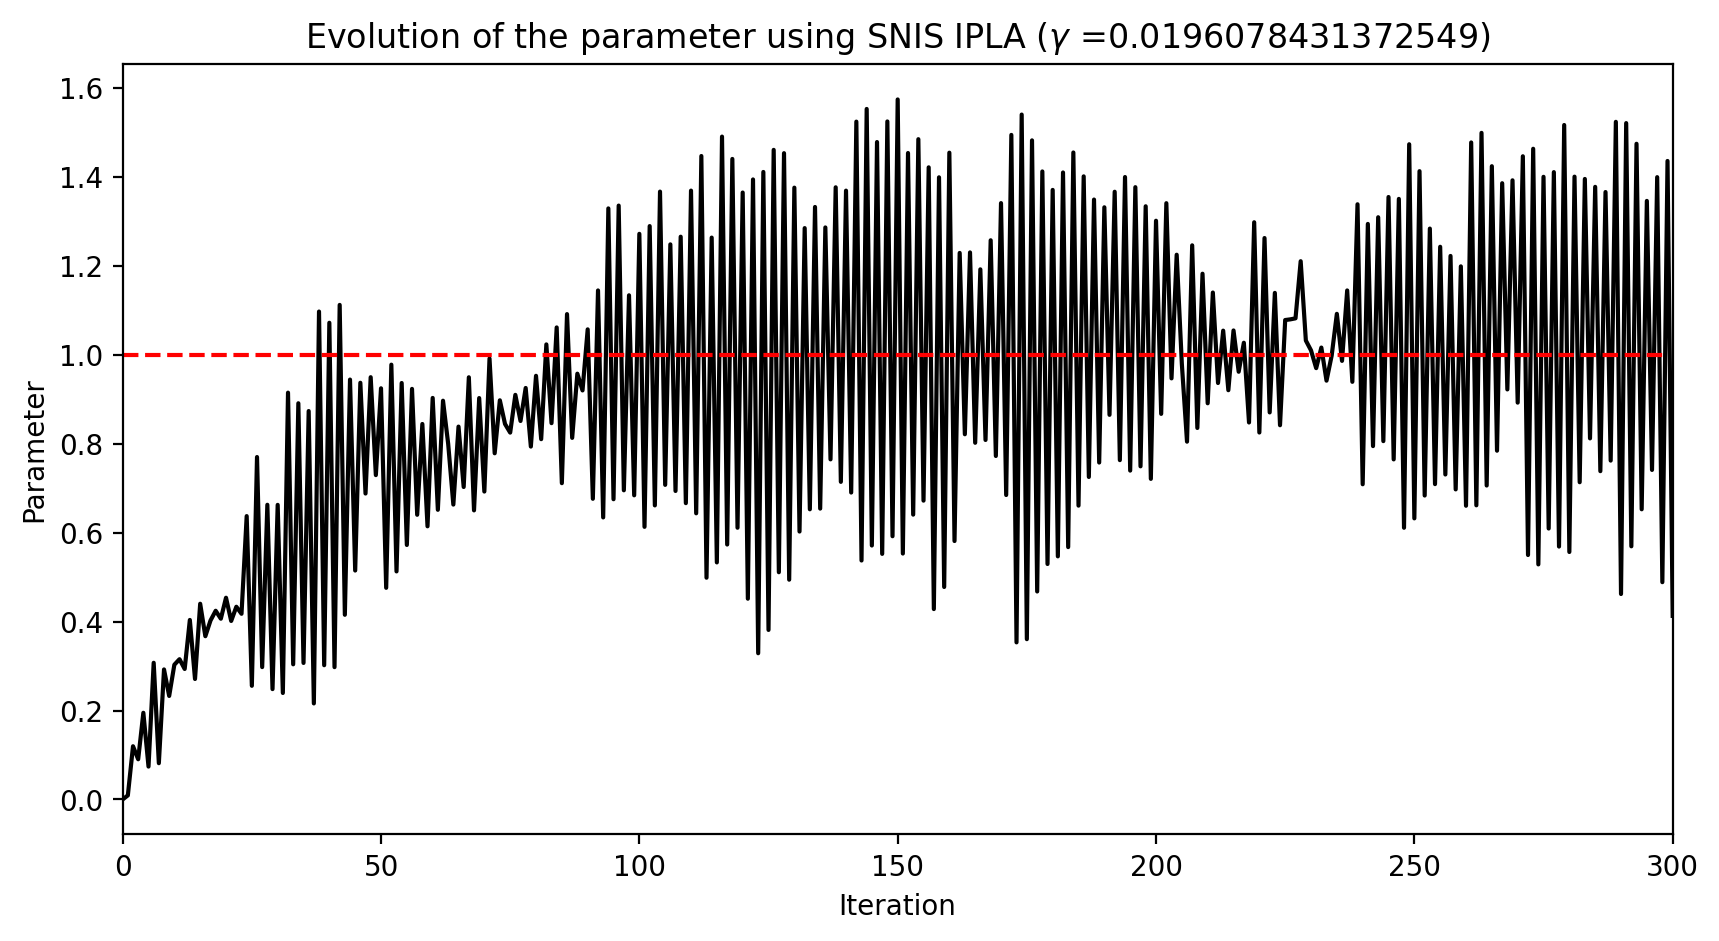

In [18]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(SNIS_IPLA_test.thetas, color = "black")
plt.plot([thdata]*nsteps, '--', color = "red")
plt.xlabel('Iteration')
plt.ylabel('Parameter')
plt.xlim([0, nsteps])
plt.title(f'Evolution of the parameter using SNIS IPLA ($\gamma$ ={gamma_SNIS})')
plt.show()